# Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill as pkl
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from eval_funcs import (
    perplexity_for_corpora,
    wasserstein_distance_embeddings,
    classify_real_vs_synth,
    compute_stat_properties,
    compute_opt_embeddings
)

from coherence_utils import compute_topic_coherence

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\loren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\loren\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Load data & Pickles

Real dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gowrishankarp/newspaper-text-summarization-cnn-dailymail")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\loren\.cache\kagglehub\datasets\gowrishankarp\newspaper-text-summarization-cnn-dailymail\versions\2


In [3]:
cnn_train = pd.read_csv(r'C:\Users\loren\.cache\kagglehub\datasets\gowrishankarp\newspaper-text-summarization-cnn-dailymail\versions\2\cnn_dailymail\train.csv')

TinyLlama

In [4]:
tinyllama_data = pd.read_csv('../tinyllama_outputs.csv').drop('Unnamed: 0', axis=1)

Qwen

In [5]:
qwen_data = pd.read_csv('../qwen_outputs.csv').drop('Unnamed: 0', axis=1)

Gemma

In [6]:
gemma_data = pd.read_csv('../gemma_1000_outputs.csv').drop('Unnamed: 0', axis=1)

Pickles

In [7]:
# TinyLlama
with open("pickles/tinyllama_stats.pkl", "rb") as f:
    tinyllama_stats = pkl.load(f)
with open("pickles/tinyllama_ppl.pkl", "rb") as f:
    tinyllama_ppl = pkl.load(f)
with open("pickles/tinyllama_wd.pkl", "rb") as f:
    tinyllama_wd = pkl.load(f)
with open("pickles/tinyllama_clf_res.pkl", "rb") as f:
    tinyllama_clf_res = pkl.load(f)
with open("pickles/tinyllama_coherence_result.pkl", "rb") as f:
    tinyllama_coherence_result = pkl.load(f)

# Qwen
with open("pickles/qwen_stats.pkl", "rb") as f:
    qwen_stats = pkl.load(f)
with open("pickles/qwen_ppl.pkl", "rb") as f:
    qwen_ppl = pkl.load(f)
with open("pickles/qwen_wd.pkl", "rb") as f:
    qwen_wd = pkl.load(f)
with open("pickles/qwen_clf_res.pkl", "rb") as f:
    qwen_clf_res = pkl.load(f)
with open("pickles/qwen_coherence_result.pkl", "rb") as f:
    qwen_coherence_result = pkl.load(f)

# Gemma
with open("pickles/gemma_stats.pkl", "rb") as f:
    gemma_stats = pkl.load(f)
with open("pickles/gemma_ppl.pkl", "rb") as f:
    gemma_ppl = pkl.load(f)
with open("pickles/gemma_wd.pkl", "rb") as f:
    gemma_wd = pkl.load(f)
with open("pickles/gemma_clf_res.pkl", "rb") as f:
    gemma_clf_res = pkl.load(f)
with open("pickles/gemma_coherence_result.pkl", "rb") as f:
    gemma_coherence_result = pkl.load(f)

# Generate Figures

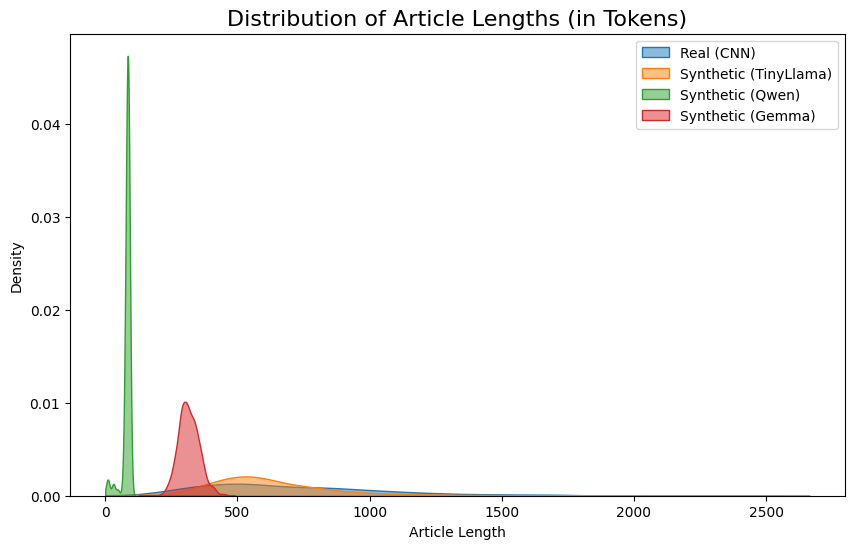

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

# Sample real data to match synthetic data size
real_texts = cnn_train['article'].sample(1000, random_state=42)
tinyllama_texts = tinyllama_data['generated_article']
qwen_texts = qwen_data['generated_article']
gemma_texts = gemma_data['generated_article']

len_real = real_texts.str.split().str.len()
len_tinyllama = tinyllama_texts.str.split().str.len()
len_qwen = qwen_texts.str.split().str.len()
len_gemma = gemma_texts.str.split().str.len()

# Create the plot
plt.figure(figsize=(10, 6))
sns.kdeplot(len_real, label='Real (CNN)', fill=True, alpha=0.5, clip=(0, 4000))
sns.kdeplot(len_tinyllama, label='Synthetic (TinyLlama)', fill=True, alpha=0.5, clip=(0, 4000))
sns.kdeplot(len_qwen, label='Synthetic (Qwen)', fill=True, alpha=0.5, clip=(0, 4000))
sns.kdeplot(len_gemma, label='Synthetic (Gemma)', fill=True, alpha=0.5, clip=(0, 4000))

plt.title('Distribution of Article Lengths (in Tokens)', fontsize=16)
plt.xlabel('Article Length')
plt.ylabel('Density')
plt.legend()
folder_path = "./figures/combined"
folder = Path(folder_path)
folder.mkdir(parents=True, exist_ok=True)
plt.savefig(folder_path + '/article_length_distribution.png')
plt.show()

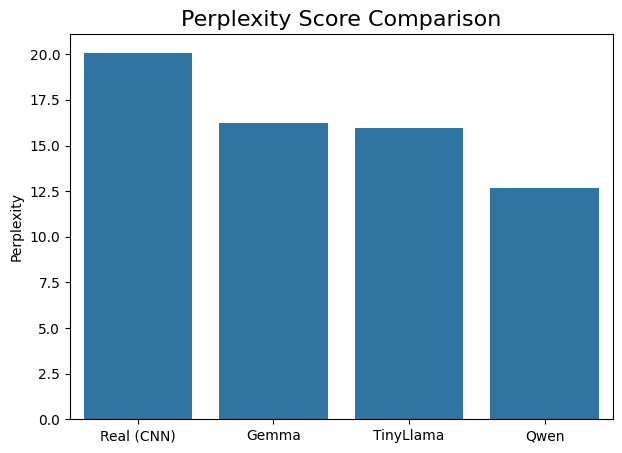

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get the data from your 'ppl' variable
ppl_scores = {
    'Real (CNN)': tinyllama_ppl['real']['corpus_ppl'],
    'TinyLlama': tinyllama_ppl['synthetic']['corpus_ppl'],
    'Qwen': qwen_ppl['synthetic']['corpus_ppl'],
    'Gemma': gemma_ppl['synthetic']['corpus_ppl']
}

ppl_scores = dict(sorted(ppl_scores.items(), key=lambda x: x[1], reverse=True))

# 2. Create the plot
plt.figure(figsize=(7, 5))
sns.barplot(x=list(ppl_scores.keys()), y=list(ppl_scores.values()))

plt.title('Perplexity Score Comparison', fontsize=16)
plt.ylabel('Perplexity')
folder_path = "./figures/combined"
folder = Path(folder_path)
folder.mkdir(parents=True, exist_ok=True)
plt.savefig(folder_path+'/perplexity_comparison.png')
plt.show()

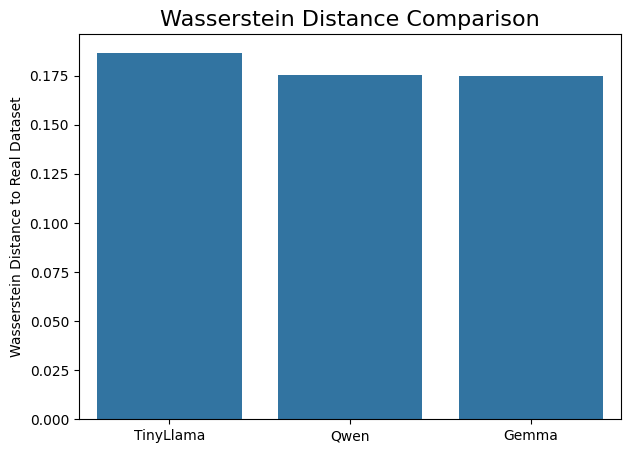

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

wd_means = {
    'TinyLlama': tinyllama_wd['mean_distance'],
    'Qwen': qwen_wd['mean_distance'],
    'Gemma': gemma_wd['mean_distance']
}

wd_means = dict(sorted(wd_means.items(), key=lambda x: x[1], reverse=True))

# 2. Create the plot
plt.figure(figsize=(7, 5))
sns.barplot(x=list(wd_means.keys()), y=list(wd_means.values()))

plt.title('Wasserstein Distance Comparison', fontsize=16)
plt.ylabel('Wasserstein Distance to Real Dataset')
folder_path = "./figures/combined"
folder = Path(folder_path)
folder.mkdir(parents=True, exist_ok=True)
plt.savefig(folder_path+'/wasserstein_dist_comparison.png')
plt.show()

Computing embeddings for REAL texts (for t-SNE)...
[embed:real_tsne] device=cuda batch_size=8 max_length(req)=2048 max_length(eff)=2048 num_docs=1000


c:\Users\loren\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\opt\modeling_opt.py:341: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


[embed:real_tsne] progress 5/125 | elapsed=3.5s | avg/batch=0.70s | ETA~84.4s
[embed:real_tsne] progress 10/125 | elapsed=6.0s | avg/batch=0.60s | ETA~69.4s
[embed:real_tsne] progress 15/125 | elapsed=8.9s | avg/batch=0.59s | ETA~65.2s
[embed:real_tsne] progress 20/125 | elapsed=11.3s | avg/batch=0.56s | ETA~59.3s
[embed:real_tsne] progress 25/125 | elapsed=14.1s | avg/batch=0.57s | ETA~56.5s
[embed:real_tsne] progress 30/125 | elapsed=16.4s | avg/batch=0.55s | ETA~51.9s
[embed:real_tsne] progress 35/125 | elapsed=19.0s | avg/batch=0.54s | ETA~48.8s
[embed:real_tsne] progress 40/125 | elapsed=21.6s | avg/batch=0.54s | ETA~45.9s
[embed:real_tsne] progress 45/125 | elapsed=24.1s | avg/batch=0.54s | ETA~42.9s
[embed:real_tsne] progress 50/125 | elapsed=27.3s | avg/batch=0.55s | ETA~41.0s
[embed:real_tsne] progress 55/125 | elapsed=30.4s | avg/batch=0.55s | ETA~38.7s
[embed:real_tsne] progress 60/125 | elapsed=33.1s | avg/batch=0.55s | ETA~35.8s
[embed:real_tsne] progress 65/125 | elapsed=

c:\Users\loren\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


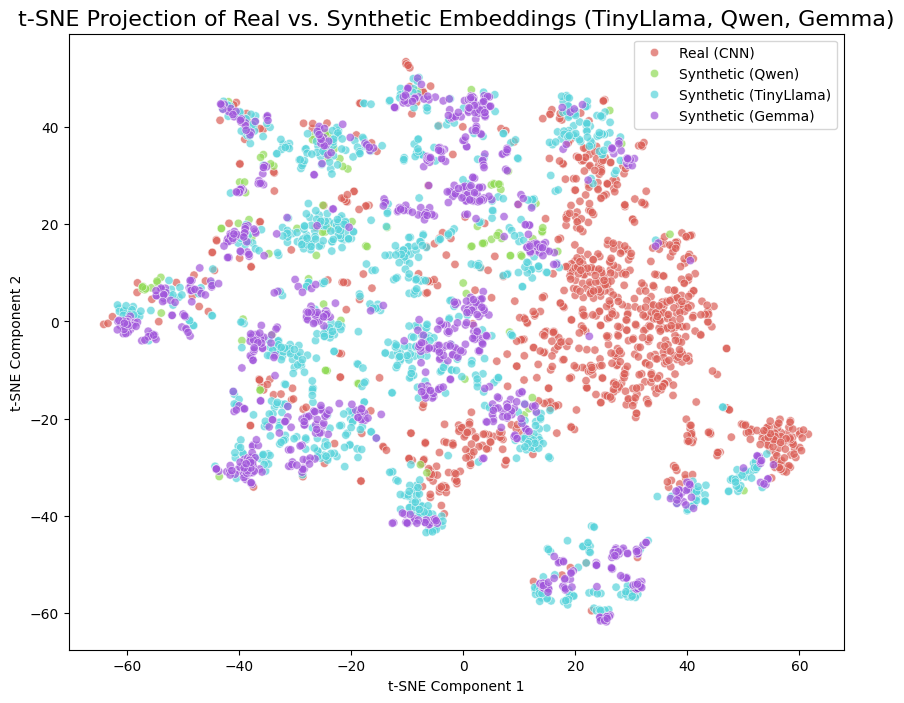

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
# from pathlib import Path  # uncomment if not already imported

# Compute embeddings

real_texts = cnn_train['article'].sample(1000, random_state=42)
qwen_texts = qwen_data['generated_article']
tiny_texts = tinyllama_data['generated_article']
gemma_texts = gemma_data['generated_article']

print("Computing embeddings for REAL texts (for t-SNE)...")
Er = compute_opt_embeddings(
    real_texts, 
    batch_size=8, 
    max_length=2048, 
    verbose=True, 
    label="real_tsne"
)

print("\nComputing embeddings for SYNTHETIC texts - Qwen (for t-SNE)...")
Es_qwen = compute_opt_embeddings(
    qwen_texts, 
    batch_size=8, 
    max_length=2048, 
    verbose=True, 
    label="synth_tsne_qwen"
)

print("\nComputing embeddings for SYNTHETIC texts - TinyLlama (for t-SNE)...")
Es_tiny = compute_opt_embeddings(
    tiny_texts, 
    batch_size=8, 
    max_length=2048, 
    verbose=True, 
    label="synth_tsne_tinyllama"
)

print("\nComputing embeddings for SYNTHETIC texts - Gemma (for t-SNE)...")
Es_gemma = compute_opt_embeddings(
    gemma_texts, 
    batch_size=8, 
    max_length=2048, 
    verbose=True, 
    label="synth_tsne_gemma"
)

# Combine embeddings and create labels
embeddings = np.concatenate([Er, Es_qwen, Es_tiny, Es_gemma], axis=0)
labels = (
    ['Real (CNN)'] * len(Er)
    + ['Synthetic (Qwen)'] * len(Es_qwen)
    + ['Synthetic (TinyLlama)'] * len(Es_tiny)
    + ['Synthetic (Gemma)'] * len(Es_gemma)
)

print(f"\nRunning t-SNE on {embeddings.shape[0]} embeddings")

# Reduce 768 dimensions down to 2
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(embeddings)

# Create dataframe and plot
df_tsne = pd.DataFrame({
    'tsne_1': tsne_results[:, 0],
    'tsne_2': tsne_results[:, 1],
    'label': labels
})

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='tsne_1', y='tsne_2',
    hue='label',
    palette=sns.color_palette("hls", 4),
    data=df_tsne,
    alpha=0.7
)

plt.title('t-SNE Projection of Real vs. Synthetic Embeddings (TinyLlama, Qwen, Gemma)', fontsize=16)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='best')

folder_path = "./figures/combined"
folder = Path(folder_path)
folder.mkdir(parents=True, exist_ok=True)
plt.savefig(folder_path + '/tsne_embeddings.png')
plt.show()